In [1]:
%matplotlib inline

import os  
os.chdir('../')



# !ls data/cifar-10-batches-py/

In [2]:
# import numpy as np
import pickle
from functools import reduce
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms


In [3]:
from preprocessing.DataLoader import DataLoader 
from preprocessing.transformation_functions import min_max_scaling, rotate_random, flip_horizontal 

data_loader = DataLoader('data/cifar-10-batches-py/', [rotate_random, flip_horizontal], [min_max_scaling])

dir(data_loader)
train_data, train_labels, test_data, test_labels = data_loader.load_data(data_loader.input_dir)



train_data

In [4]:

training_instance = data_loader.execute()



(120000, 32, 32, 3)
(10000, 32, 32, 3)
(120000,)


In [8]:
??DataLoader

Init signature:
DataLoader(
    input_dir,
    data_augmentation_functions=[],
    data_prep_functions=[],
)
Docstring:      <no docstring>
Source:        
class DataLoader:
    def __init__(self, input_dir, data_augmentation_functions=[], data_prep_functions=[]):
        self.input_dir = input_dir
        self.data_augmentation_functions = data_augmentation_functions
        self.data_prep_functions = data_prep_functions
        
    
    def execute(self):
        """Returns
            
           train_data, train_labels, test_data, test_labels, 
       
       """
        train_data, train_labels, test_data, test_labels = self.load_data(self.input_dir)
        
        train_data = self.append_augmentations(train_data, self.data_augmentation_functions)
        train_labels = np.tile(train_labels, len(self.data_augmentation_functions) + 1)
        train_data, test_data = self.preprocess_images(train_data, self.data_prep_functions), \
                                self.preprocess_

In [6]:


np.array(map(lambda x: min_max_scaling, train_data))

array(<map object at 0x7f1aab741d90>, dtype=object)

In [7]:
def min_max_scaling(x):
    """
        argument
            - x: input array
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-np.min(x)) / (np.max(x)-np.min(x))
    return x   




In [12]:
def get_train_loader(batch_size, train_data, train_labels):

    dataset = TensorDataset(torch.Tensor(train_data.transpose(0,3,1,2)),
                            torch.LongTensor(train_labels))

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

In [11]:
def plot_image(img_object, label = None):
    
    plt.title(label)
    plt.imshow(img_object)

    

np.vectorize(min_max_scaling)(train_data)

/home/obs/convnet-cifar/preprocessing/transformation_functions.py:17: RuntimeWarning: invalid value encountered in ubyte_scalars
  return (x - np.min(x)) / (np.max(x) - np.min(x))
/home/obs/convnet-cifar/preprocessing/transformation_functions.py:17: RuntimeWarning: invalid value encountered in long_scalars
  return (x - np.min(x)) / (np.max(x) - np.min(x))


KeyboardInterrupt: 

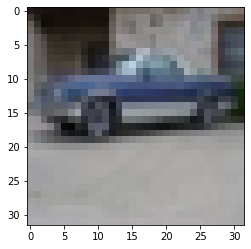

In [7]:
plot_image(train_data[0])
#train_data, train_labels, test_data, test_labels, label_encodings = data_loader.execute()

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class VanillaCNN(torch.nn.Module):
    
    def __init__(self, num_classes=10):
        super(VanillaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.pool = nn.MaxPool2d(2,2, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)
         
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 10) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
     #   x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    


In [11]:
class CNNWithNorm(torch.nn.Module):
    
    def __init__(self, num_classes=10):
        super(CNNWithNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)

        self.pool = nn.MaxPool2d(2,2, padding=1)
        
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.conv4 = nn.Conv2d(16, 32, 3)
        
        self.conv5 = nn.Conv2d(32, 32, 3)
        self.conv6 = nn.Conv2d(32, 32, 3)
         
        self.fc1 = nn.Linear(128, 84)
        self.fc2 = nn.Linear(84, 10) 
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [12]:
class CNNNorm(torch.nn.Module):
    
    def __init__(self, num_classes=10):
        super(CNNNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.batch2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2,2, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.batch4 = nn.BatchNorm2d(128)       

        self.conv5 = nn.Conv2d(128, 256, 3)
        self.batch5 = nn.BatchNorm2d(256)       

        self.conv6 = nn.Conv2d(256, 256, 3)
        self.batch6 = nn.BatchNorm2d(256)               
        
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 10) 
        
    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = self.pool(x)
     #   x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.batch4(self.conv4(F.relu(self.batch3(self.conv3(x)))))))
        x = F.relu(self.batch6(self.conv6(F.relu(self.batch5(self.conv5(x))))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    


In [13]:
model = CNNNorm()


#    transform_train = transforms.Compose([
#        transforms.RandomCrop(32, padding=4),
#        transforms.RandomHorizontalFlip(),
#        transforms.ToTensor(),
#        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#    ])

In [14]:
import torch.optim as optim
from torch.utils.data import TensorDataset


def loss_and_optimizer(net, learning_rate):
    
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)
    
    return loss, optimizer

In [15]:
training_loss, validation_loss, batch_list = [],[],[]

def train_model(net, batch_size, n_epochs, learning_rate, train_data, train_labels, test_data, test_labels):
    global training_loss, validation_loss, accuracy_list
    training_loss, validation_loss, accuracy_list = [], [], []
    train_loader = get_train_loader(batch_size, train_data, train_labels)
    
    test_loader = get_train_loader(None, test_data, test_labels)
    n_batches = len(train_loader)
    loss, optimizer = loss_and_optimizer(net, learning_rate)
    
    for epoch in range(n_epochs):
        running_loss = 0
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            
            inputs, labels = data
           # inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            
            running_loss += loss_size.data.item() * batch_size
            #debug_loss.append(loss_size.data.item() * batch_size)
            total_train_loss += loss_size.data.item()
            
            if i % 200 == 0: 
                print('Iteration {0}: \n  \
                       Running Loss Is {1}'
                      .format(i, running_loss/(200 * batch_size)))
                running_loss = 0
            
                       
        for inputs, labels in test_loader: 
            val_outputs = net(inputs)
            val_loss = loss(val_outputs, labels).data.item()
            accuracy = (torch.max(val_outputs, 1).indices == labels).sum().item()/test_data.shape[0]
            print(val_loss)
            print("Epoch {0}, \n \
                   Train Loss: {1} \n \
                   Validation Loss: {2} \
                   Accuracy: {3}".format(str(epoch), total_train_loss/(train_data.shape[0]/batch_size), val_loss, accuracy))
            
            accuracy_list.append(accuracy)
        validation_loss.append(val_loss)
        training_loss.append(total_train_loss/(train_data.shape[0]/batch_size))
        running_loss = 0

                
    
    return training_loss, validation_loss, accuracy_list, 
                
            
            
        
            
        

In [16]:


import pandas as pd 
new_vanilla = CNNNorm()
#new_vanilla = VanillaCNN_2()

losses = train_model(new_vanilla, 24, 20, .001, train_data, train_labels, test_data, test_labels)

Iteration 0: 
                         Running Loss Is 0.011521519422531127
Iteration 200: 
                         Running Loss Is 1.9581619185209274
Iteration 400: 
                         Running Loss Is 1.7706145721673965
Iteration 600: 
                         Running Loss Is 1.6586353659629822
Iteration 800: 
                         Running Loss Is 1.5823347103595733
Iteration 1000: 
                         Running Loss Is 1.4477832144498826
Iteration 1200: 
                         Running Loss Is 1.371773143708706
Iteration 1400: 
                         Running Loss Is 1.337481843829155
Iteration 1600: 
                         Running Loss Is 1.2491116484999656
1.1623430252075195
Epoch 0, 
                    Train Loss: 1.5366353027701378 
                    Validation Loss: 1.1623430252075195                    Accuracy: 0.5835


OSError: [Errno 12] Cannot allocate memory

In [ ]:
df = pd.DataFrame(data=losses, index=['train_loss','validation_loss', 'accuracy']).T
df[['train_loss', 'validation_loss']].plot(kind='line')
plt.xlabel('epochs')
plt.show()



In [ ]:
sdf = pd.DataFrame(data=debug_loss)

(sdf[[0]]/20).plot(kind='line')

In [ ]:

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as transforms

In [ ]:
new = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [ ]:
ls data/

In [ ]:
test_loader = get_train_loader(None, test_data, test_labels)


In [ ]:
res = new_vanilla(torch.Tensor(test_data.transpose(0,3,1,2)))

In [ ]:
debug_loss

In [ ]:
train_data.shape

In [ ]:
(torch.max(res, 1).indices == torch.Tensor(test_labels)).sum().item()

In [ ]:
test_data.shape